In [2]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

%matplotlib inline
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import numpy

from pprint import pprint
import operator

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# Data Exploration & Feature Processing

Dataset is first loaded into dictionary. Subsequently, data is explored (no. of persons in dataset, features with/without useful information, visualisation of features etc.) with the goal of understanding the data better and selecting the features to use for training the algorithm.

In [3]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
# Structure of dataset
print "The general structure of the dataset is as follows:\n"
print (data_dict.items()[0])
print "\n"

### Key Information

# During some preliminary analysis and data visualisation, an unnecessary data point, "TOTAL", was found to be 
# present. As this is actually a sum of all other persons in dataset, its not useful here and is removed.
data_dict.pop('TOTAL', None)

# No. of persons in dataest
print "Total number of persons in dataset:", len(data_dict), "\n"

The general structure of the dataset is as follows:

('METTS MARK', {'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38})


Total number of persons in dataset: 145 



In [5]:
# This is to see see how many data pts are available for each feature. Since there are 145 persons in total, the
# max number of data pts possible for a feature is 145. If number is too low, the feature is mostly NaN, and we 
# know it wouldn't be ideal to use that feature.
available_features_list = (data_dict.items()[0][1]).keys()
feature_count = {}
for feature in available_features_list:
    count = 0
    for values in data_dict.values():
        if values[feature] != "NaN":
            count += 1
    feature_count[feature] = count

sorted_feature_count = sorted(feature_count.items(), key=operator.itemgetter(1), reverse=True)
print "No. of data pts available for each features (descending order):\n"
print (sorted_feature_count)

No. of data pts available for each features (descending order):

[('poi', 145), ('total_stock_value', 125), ('total_payments', 124), ('email_address', 111), ('restricted_stock', 109), ('exercised_stock_options', 101), ('salary', 94), ('expenses', 94), ('other', 92), ('to_messages', 86), ('shared_receipt_with_poi', 86), ('from_messages', 86), ('from_poi_to_this_person', 86), ('from_this_person_to_poi', 86), ('bonus', 81), ('long_term_incentive', 65), ('deferred_income', 48), ('deferral_payments', 38), ('restricted_stock_deferred', 17), ('director_fees', 16), ('loan_advances', 3)]


In [6]:
cleaned_feature_list = []
for element in sorted_feature_count:
    if element[1]>=(145/2) and element[0]!="poi" and element[0]!="email_address" and element[0]!="other":
        cleaned_feature_list.append(element[0])

print cleaned_feature_list
print len(cleaned_feature_list), "features"

['total_stock_value', 'total_payments', 'restricted_stock', 'exercised_stock_options', 'salary', 'expenses', 'to_messages', 'shared_receipt_with_poi', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'bonus']
12 features


<h3>Creating/processing email features</h3>

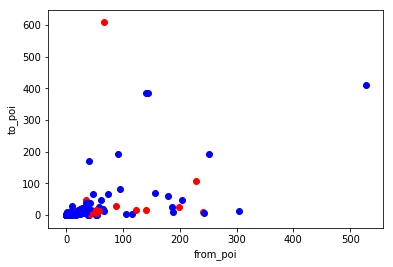

In [7]:
# Try visualizing features to identify possible trends
for key, value in data_dict.items():
    from_poi = value["from_poi_to_this_person"]
    to_poi = value["from_this_person_to_poi"]
    if value["poi"]==1:
        plt.scatter(from_poi, to_poi, color="r")
    if value["poi"]==0:
        plt.scatter(from_poi, to_poi, color="b")
    
plt.xlabel("from_poi")
plt.ylabel("to_poi")
plt.show()

However, this is not a good representation as it is not normalised to the number of emails sent or received by people. Therefore, for each person, the fraction of emails sent/received that were to/from POI was calculated and then added to dataset. The data was also visualised.

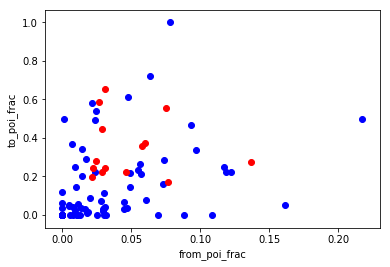

In [8]:
def compute_fraction(A,B):
    if A == "NaN" or B == "NaN":
        return 0

    return (1.0*A)/B

for key, value in data_dict.items():
    # compute fraction
    from_poi_frac = compute_fraction(value["from_poi_to_this_person"], value["to_messages"])
    to_poi_frac = compute_fraction(value["from_this_person_to_poi"], value["from_messages"])
    
    # store in data_dict
    value["from_poi_frac"] = from_poi_frac
    value["to_poi_frac"] = to_poi_frac
    
    if value["poi"]==1:
        plt.scatter(from_poi_frac, to_poi_frac, color="r")
    if value["poi"]==0:
        plt.scatter(from_poi_frac, to_poi_frac, color="b")
    
plt.xlabel("from_poi_frac")
plt.ylabel("to_poi_frac")
plt.show()

As such, the new list of features to consider would be as follows:

In [9]:
cleaned_feature_list.remove("from_poi_to_this_person")
cleaned_feature_list.remove("to_messages")
cleaned_feature_list.remove("from_this_person_to_poi")
cleaned_feature_list.remove("from_messages")

cleaned_feature_list.append("from_poi_frac")
cleaned_feature_list.append("to_poi_frac")

print cleaned_feature_list
print len(cleaned_feature_list), "features"

['total_stock_value', 'total_payments', 'restricted_stock', 'exercised_stock_options', 'salary', 'expenses', 'shared_receipt_with_poi', 'bonus', 'from_poi_frac', 'to_poi_frac']
10 features


In [93]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'bonus', 'total_stock_value', 'total_payments', 'restricted_stock', \
                 'exercised_stock_options', 'expenses', 'shared_receipt_with_poi', 'from_poi_frac', 'to_poi_frac']

### Task 2: Remove outliers

### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict
#pprint (my_dataset)

In [94]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

<h3>Feature selection</h3>
Tried employing feature selection, seems to change result for various k. need to try which works best. for now, its commented out.

In [95]:
# from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif

# selector = SelectKBest(f_classif, k=7)
# selector.fit(features, labels)

# features = selector.transform(features)

#print selector.scores_

#print len(features)

In [96]:
### Split data into training data and test data
from sklearn.model_selection import train_test_split

# random_state = 42 is the seed for randomizing the split.
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

#print type(features_train)
#print features_train
    

# Algorithms

<h3>Common Functions</h3>

In [97]:
def evaluate(labels_test, pred):
    acc = accuracy_score(labels_test, pred)
    ps = precision_score(labels_test, pred)
    rs = recall_score(labels_test, pred)

    print "acc:", acc
    print "precision_score:", ps
    print "recall_score:", rs

    # Evaluation criteria
    print "\n"
    if ps < 0.3 or rs < 0.3:
        print "Reject, precision and/or recall score < 0.3"
    else:
        print "Accept"

<h3>Decision Tree</h3>

In [98]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

params = {'min_samples_split':[2,3,4,5,6,7,8,9,10], 'criterion':('gini', 'entropy')}
clf_tree = tree.DecisionTreeClassifier()
clf = GridSearchCV(clf_tree, params)

clf.fit(features_train, labels_train)

print clf.best_params_

pred = clf.predict(features_test)

evaluate(labels_test, pred)

{'min_samples_split': 9, 'criterion': 'gini'}
acc: 0.840909090909
precision_score: 0.25
recall_score: 0.2


Reject, precision and/or recall score < 0.3


<h3>Naive Bayes</h3>

In [99]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

clf.fit(features_train, labels_train)

pred = clf.predict(features_test)

evaluate(labels_test, pred)

acc: 0.886363636364
precision_score: 0.5
recall_score: 0.6


Accept


<h3>SVM</h3>

In [100]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

# Since the scale of data varies significantly across the various features, feature scaling is required
# before SVM can be used.
scaler = MinMaxScaler()
rescaled_features_train = scaler.fit_transform(features_train)
rescaled_features_test = scaler.fit_transform(features_test)

params = {'C':[10,100,1000,10000], 'gamma':[10,100,1000,10000]}
clf_svc = SVC(kernel="rbf")
clf = GridSearchCV(clf_svc, params)

clf.fit(rescaled_features_train, labels_train)

print clf.best_params_

pred = clf.predict(rescaled_features_test)

evaluate(labels_test, pred)

{'C': 10, 'gamma': 100}
acc: 0.886363636364
precision_score: 0.0
recall_score: 0.0


Reject, precision and/or recall score < 0.3


<h3>K Nearest Neighbors</h3>

In [101]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
clf_knn = KNeighborsClassifier()
clf = GridSearchCV(clf_knn, params)
clf.fit(features_train, labels_train)

print clf.best_params_

pred = clf.predict(features_test)

evaluate(labels_test, pred)

{'n_neighbors': 3}
acc: 0.909090909091
precision_score: 0.666666666667
recall_score: 0.4


Accept


<h3>AdaBoost</h3>

In [102]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()

clf.fit(features_train, labels_train)

pred = clf.predict(features_test)

#print clf.estimators_

evaluate(labels_test, pred)


acc: 0.795454545455
precision_score: 0.25
recall_score: 0.4


Reject, precision and/or recall score < 0.3


< do feature selection here, and try running various algos >
< try finding importances using sklearn and run algos on those features >
< try pca + algos >


<h3>PCA + Algos</h3>
<br>
Attempted deploying PCA to transform finance related features. Subsequently ran SVM, Decision Tree and K Nearest Neighbours algorithms on the transformed data.

In [20]:
### trying PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(features_train)

#print pca.explained_variance_ratio_

#print "first pc", pca.components_[0]
#print "second pc", pca.components_[1]
#print "third pc", pca.components_[2]

trans_features_train = pca.transform(features_train)

# i=0
# for point in transformed_features:
#     x = point[0]
#     y = point[1]
#     plt.scatter( x, y )
#     if labels[i] == 1:
#         plt.scatter(x, y, color="r")
#     else:
#         plt.scatter(x, y, color="b")
#     i+=1

# plt.xlabel("x")
# plt.ylabel("y")
# plt.show()

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#params = {'C':[1,10,100,1000,10000], 'gamma':[1,10,100,1000,10000]}
svc = SVC(kernel='rbf')
svc.fit(trans_features_train, labels_train)

trans_features_test = pca.transform(features_test)
svc_pred = svc.predict(trans_features_test)

In [22]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(min_samples_split=10)
clf.fit(trans_features_train, labels_train)
tree_pred = clf.predict(trans_features_test)


In [23]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(trans_features_train, labels_train)
knn_pred = clf.predict(trans_features_test)

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc = accuracy_score(labels_test, svc_pred)
ps = precision_score(labels_test, svc_pred)
rs = recall_score(labels_test, svc_pred)

print "svc_acc:", acc
print "svc_precision_score:", ps
print "svc_recall_score:", rs

print "\n"

acc1 = accuracy_score(labels_test, tree_pred)
ps1 = precision_score(labels_test, tree_pred)
rs1 = recall_score(labels_test, tree_pred)

print "tree_acc:", acc1
print "tree_precision_score:", ps1
print "tree_recall_score:", rs1

print "\n"

acc2 = accuracy_score(labels_test, knn_pred)
ps2 = precision_score(labels_test, knn_pred)
rs2 = recall_score(labels_test, knn_pred)

print "knn_acc:", acc2
print "knn_precision_score:", ps2
print "knn_recall_score:", rs2

svc_acc: 0.886363636364
svc_precision_score: 0.0
svc_recall_score: 0.0


tree_acc: 0.863636363636
tree_precision_score: 0.333333333333
tree_recall_score: 0.2


knn_acc: 0.818181818182
knn_precision_score: 0.0
knn_recall_score: 0.0


# Other Algos (in progress)

In [ ]:
### Feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rescaled_features = scaler.fit_transform(features)
print rescaled_features[0:3]

In [ ]:
### Visualizing data
for point in rescaled_features:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [ ]:
### Split data into training data and test data
from sklearn.model_selection import train_test_split

# random_state = 42 is the seed for randomizing the split.
features_train, features_test, labels_train, labels_test = \
    train_test_split(rescaled_features, labels, test_size=0.3, random_state=4)
    
print labels_test
print labels

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# pca.fit(features)

# pipe = make_pipeline(PCA())
# #pipe.set_params(pca__n_components=5)
# pipe

In [ ]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html



# Create a dictionary to store pred value of various classifiers
pred_dict = {}

# Provided to give you a starting point. Try a variety of classifiers.
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()

In [ ]:
# Classifier 1: Decision Tree
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

pred_dict['decision_tree'] = pred

In [ ]:
# Classifier 2: SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

params = {'C':[1,10,100,1000,10000], 'gamma':[1,10,100,1000,10000]}
svc = SVC(kernel='rbf')
clf = GridSearchCV(svc, params)
clf.fit(features_train, labels_train)
print clf.best_params_

pred = clf.predict(features_test)


pred_dict['SVM'] = pred

In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# # Example starting point. Try investigating other evaluation techniques!
# from sklearn.cross_validation import train_test_split
# features_train, features_test, labels_train, labels_test = \
#     train_test_split(features, labels, test_size=0.3, random_state=42)
    

#evaluation    
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from pprint import pprint
print labels_test
pprint(pred_dict)

for key, value in pred_dict.items():
    print key.upper()
    acc = accuracy_score(labels_test, value)
    ps = precision_score(labels_test, value)
    rs = recall_score(labels_test, value)

    print "acc:", acc
    print "precision_score:", ps
    print "recall_score:", rs
    print "\n"

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)